# Student Grade Exploratory Data Analysis Project

## Shaping and understanding the data we are working with

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('student-dataset.csv')
df.drop(columns=['latitude', 'longitude', 'portfolio.rating', 'coverletter.rating', 'refletter.rating', 'ethnic.group'], inplace=True)
df.head()

,id,name,nationality,city,gender,age,english.grade,math.grade,sciences.grade,language.grade
0,0,Kiana Lor,China,Suzhou,F,22,3.5,3.7,3.1,1.0
1,1,Joshua Lonaker,United States of America,Santa Clarita,M,22,2.9,3.2,3.6,5.0
2,2,Dakota Blanco,United States of America,Oakland,F,22,3.9,3.8,3.2,5.0
3,3,Natasha Yarusso,United States of America,Castro Valley,F,20,3.3,2.8,3.2,5.0
4,4,Brooke Cazares,Brazil,São José dos Campos,F,21,3.7,2.6,3.4,1.0


We are provided information on student nationality, gender, and age which will be useful when making predictions based on demographics.

In [306]:
df.drop(df.columns[0], axis=1).describe()

,age,english.grade,math.grade,sciences.grade,language.grade
count,307.000000,307.000000,307.000000,307.000000,307.000000
mean,21.964169,3.369707,3.414332,3.446580,4.396417
std,1.248013,0.538724,0.476839,0.509081,0.996474
min,19.000000,1.500000,2.100000,1.400000,1.000000
25%,21.000000,3.100000,3.100000,3.200000,4.000000
50%,22.000000,3.500000,3.500000,3.600000,5.000000
75%,23.000000,3.800000,3.800000,3.800000,5.000000
max,26.000000,4.000000,4.000000,4.000000,5.000000


There is a significantly larger standard deviation in the Language grade, indicating that students perform inconsitently as a whole.

Students are achieving the highest grades in their Language classes, followed by Science, then lastly Math and English.

## What are the top-performing nationalities for each subject?

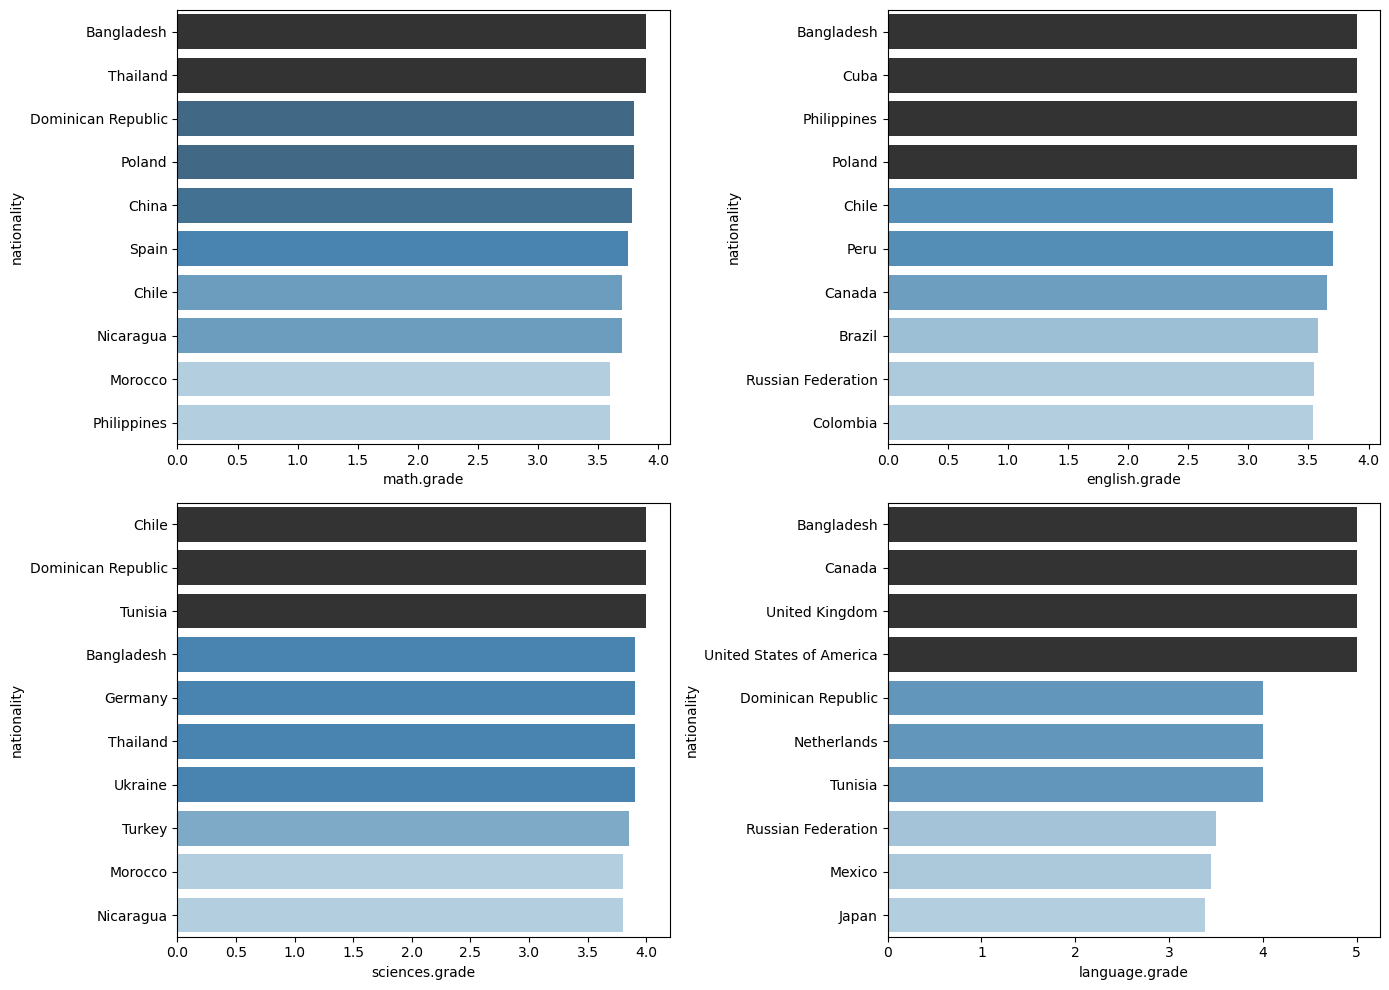

In [307]:
subjects = ['math.grade', 'english.grade', 'sciences.grade', 'language.grade']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, subject in enumerate(subjects):
    ax = axes[i // 2, i % 2]
    top_10 = df.groupby('nationality')[subject].mean().nlargest(10).reset_index()
    sns.barplot(data=top_10, x=subject, y='nationality', hue=subject, legend=False, ax=ax, palette = 'Blues_d')
    plt.tight_layout()

People from Bangladesh were consistently the highest achievers in all subjects besides sciences.

## Which gender stacks up to having better grades for each subject?

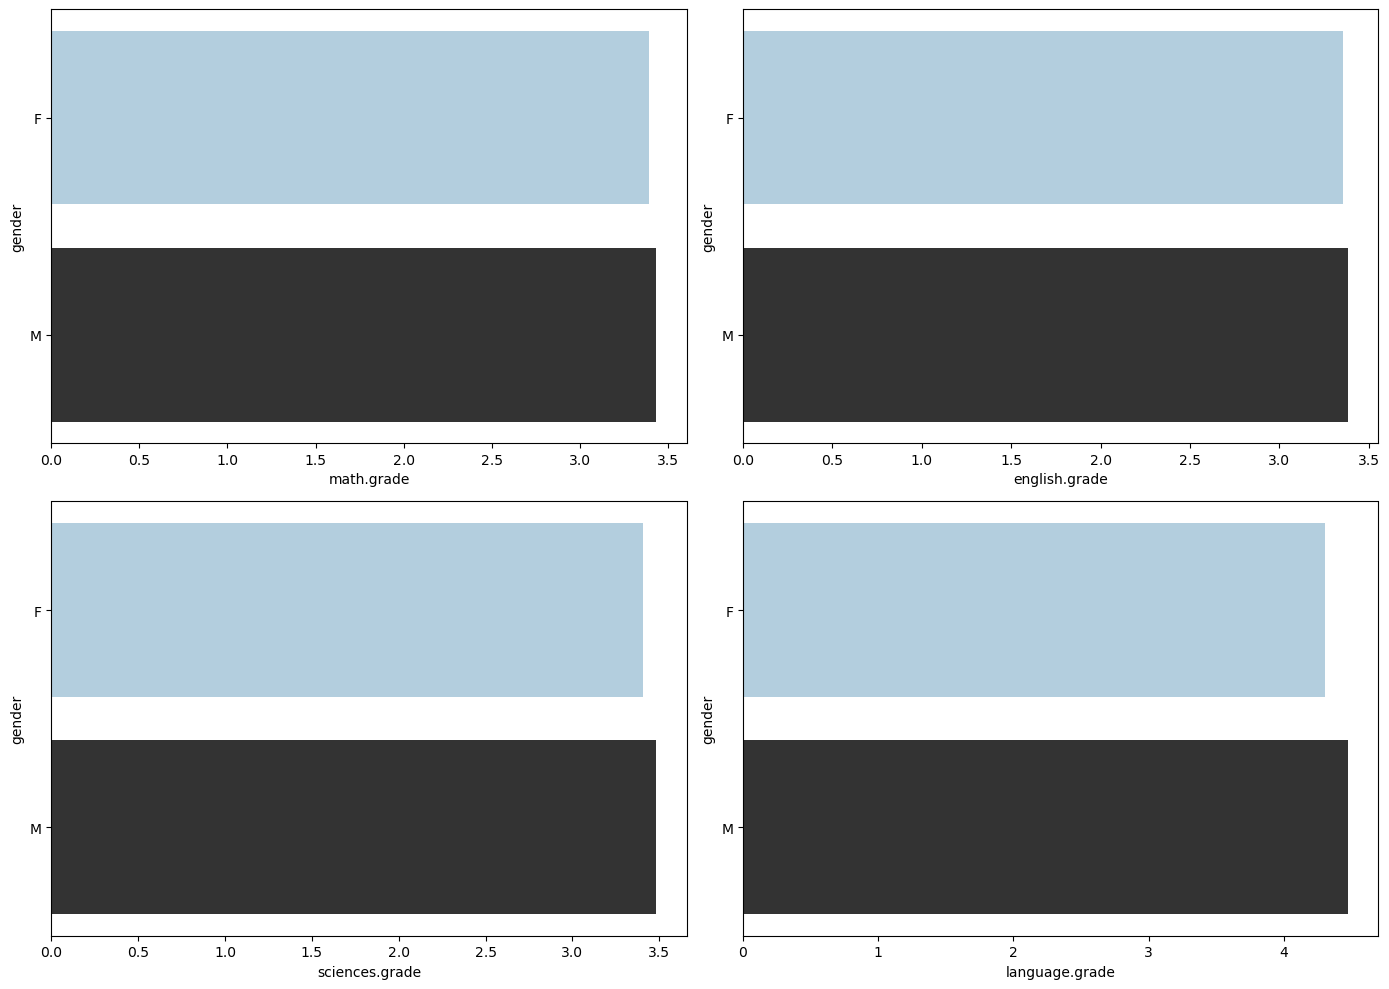

In [308]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
for i, subject in enumerate(subjects):
    ax = axes[i // 2, i % 2]
    filtered_df = df.query('gender != "other"')
    genders = filtered_df.groupby('gender')[subject].mean().reset_index()
    sns.barplot(data=genders, x=subject, y='gender', hue=subject, legend=False, ax=ax, palette = 'Blues_d')
    plt.tight_layout()

Interestingly, males outperformed females in all subjects.

## In which ages are we observing stronger grades?

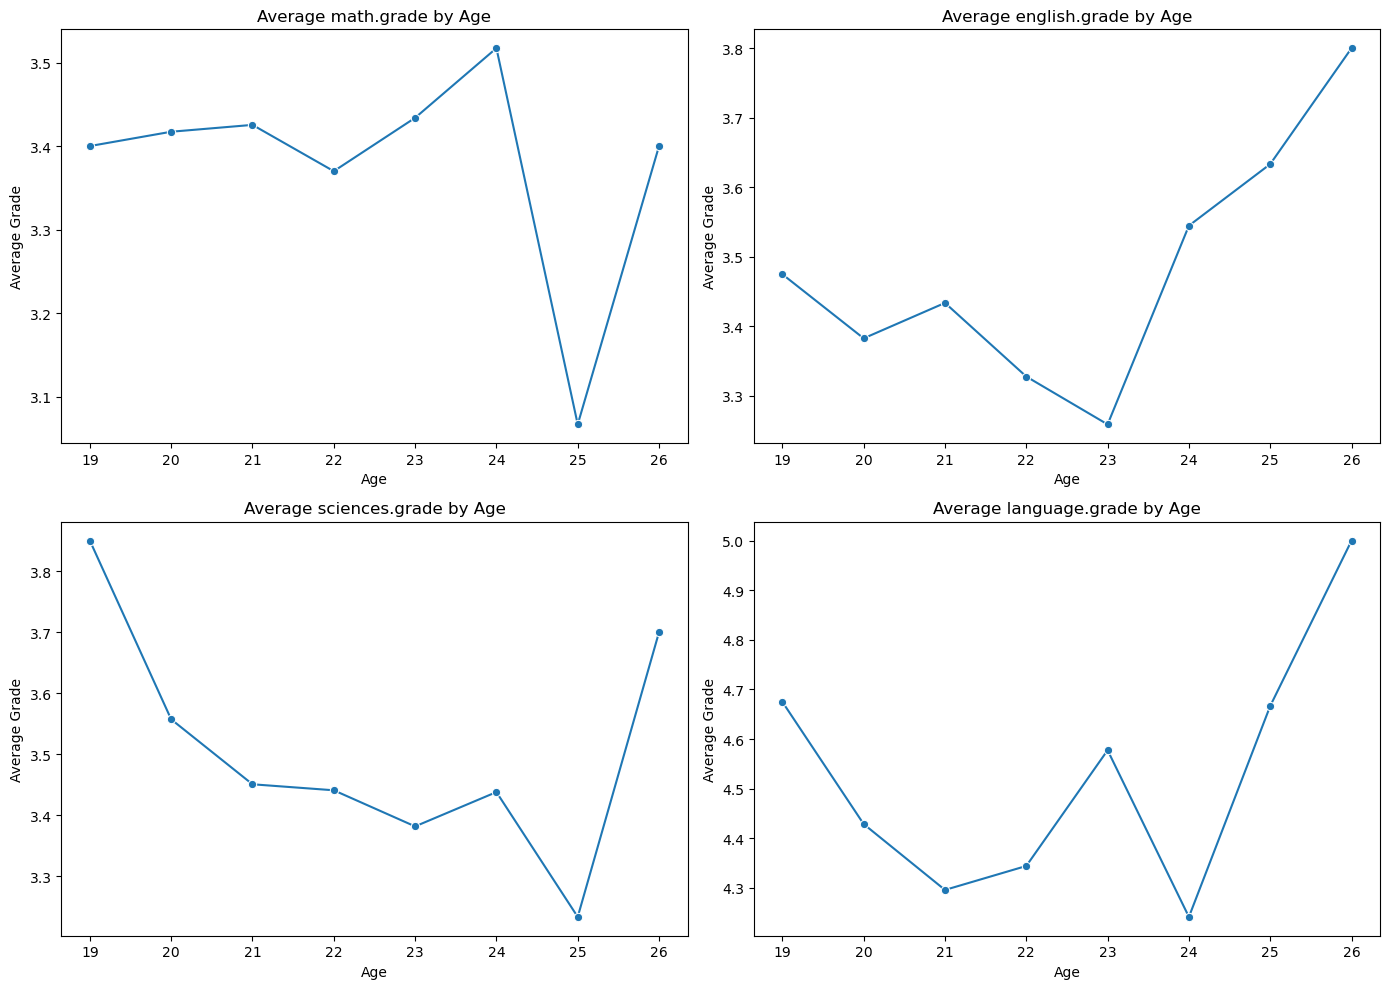

In [309]:
age_performance = df.groupby('age')[['math.grade', 'english.grade', 'sciences.grade', 'language.grade']].mean()
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
for i, subject in enumerate(subjects):
    ax = axes[i // 2, i % 2] 
    sns.lineplot(x=age_performance.index, y=age_performance[subject], ax=ax, marker='o')
    ax.set_title(f'Average {subject} by Age')
    ax.set_xlabel('Age')
    ax.set_ylabel('Average Grade')
plt.tight_layout()
plt.show()

25 year olds proved to be the weakest age for both science and maths.
26 year olds were both the strongest in both english and languages. 
24 year olds were best at maths, and 19 year olds the best at science.
The analysis may not be entirely accurate, and runs the risk of being skewed as the distribution of ages in the data, as seen in section one, implies the majority of ages were clustered towards the 20-24 years old range. There were a limited number of 19 and 26 year old students, hence further investigation would be needed to confirm any trends for certain. 

## What are the cities with the worst language grades?
An important question to ask since there the largest standard deviation was observed in the language subject.

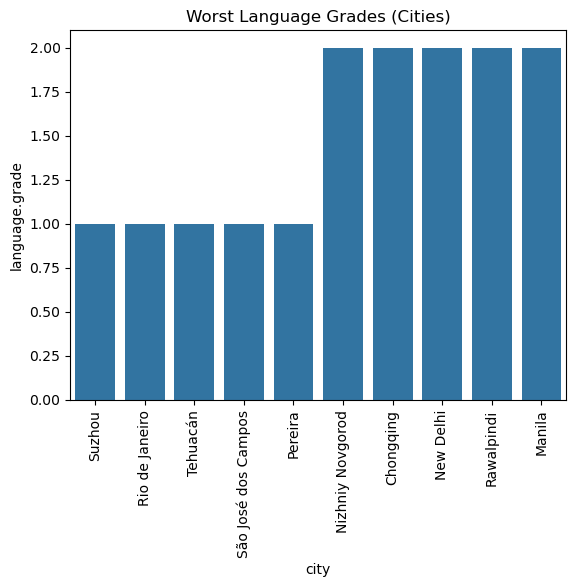

In [310]:
language_grades_city = df.groupby('city')['language.grade'].mean().reset_index().sort_values(by='language.grade', ascending = True).head(10)
ax = sns.barplot(x='city', y='language.grade',data = language_grades_city)
plt.title('Worst Language Grades (Cities)')
plt.xticks(rotation=90)
plt.show()

Asian and South American cities appear to be severly underperforming in languages, given both the median and maximum were 5.0.

When observing the top four nationalities for languages, notice three of them were in the Anglosphere (Canada, United States, and the UK) which could suggest native English speakers may be likely to perform higher in this subject.

## Does achieving high grades in one subject suggest the same for another?

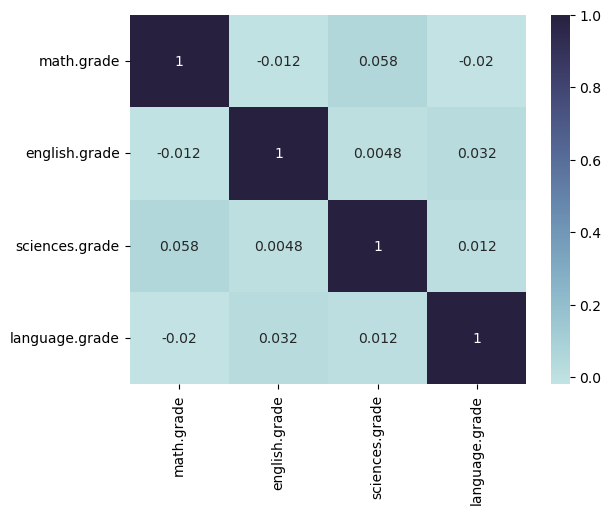

In [311]:
corr_data = df[['math.grade', 'english.grade', 'sciences.grade', 'language.grade']]
custom_cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.heatmap(corr_data.corr(), annot=True, cmap=custom_cmap)
plt.show()

The correlation matrix heatmap implies that there is no correlation between subject grades. Hence, we are going to use single-variable prediction for our models.

# Training a machine learning model
Predicting english grades based on the demographic of an input student (nationality, city, gender, age)

In [312]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

df = pd.read_csv('student-dataset.csv')
df.drop(columns=['latitude', 'longitude', 'portfolio.rating', 'coverletter.rating', 'refletter.rating', 'ethnic.group'], inplace=True)

le_nationality = LabelEncoder()
le_city = LabelEncoder()
le_gender = LabelEncoder()

df['nationality'] = le_nationality.fit_transform(df['nationality'])
df['city'] = le_city.fit_transform(df['city'])
df['gender'] = le_gender.fit_transform(df['gender'])

X = df[['nationality', 'city', 'age', 'gender']]
y = df['english.grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

person = [
    le_nationality.transform(['China'])[0],  
    le_city.transform(['Suzhou'])[0],        
    22,                                      
    le_gender.transform(['F'])[0]            
]

predicted_grade = model.predict([person])

print(f"Predicted English Grade: {predicted_grade[0]}")

Mean Squared Error: 0.29838600869288995
R² Score: -0.471167597531545
Predicted English Grade: 3.2940000000000005


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Discussing the model

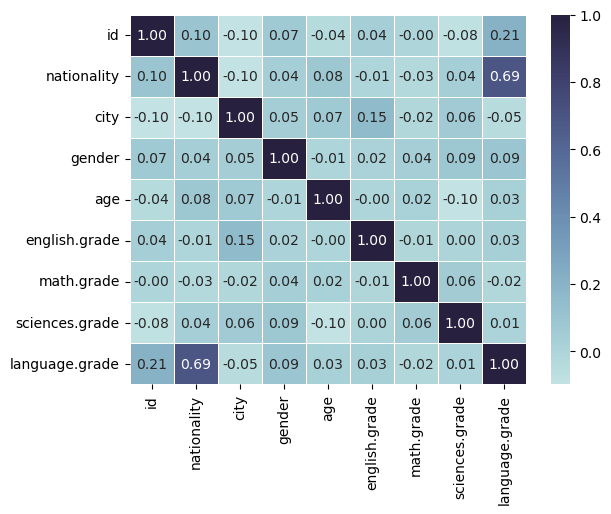

In [313]:
test_df = df.drop(columns=['name'])
test_df.head()
corr_matrix = test_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt='.2f', linewidths=0.5)
plt.show()

It makes it difficult to train an accurate model to predict english grades as none of the features of the dataset have strong correlations to english grade. To improve the model, better feature selection and more data is necessary. 

Language grade alternatively has slightly higher correlations with nationality, if we select this for our model instead we may see improvements.

## Attempting a (slightly) improved model

In [314]:
X = df[['nationality', 'city', 'age', 'gender']]
y = df['language.grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

person = [
    le_nationality.transform(['China'])[0],  
    le_city.transform(['Suzhou'])[0],        
    22,                                      
    le_gender.transform(['F'])[0]            
]

predicted_grade = model.predict([person])

print(f"Predicted Language Grade: {predicted_grade[0]}")

Mean Squared Error: 0.42714048387096765
R² Score: 0.4179624175824177
Predicted Language Grade: 1.695


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


As we see, slight improvement with the MSE and R2 scores suggest our model has improved it's predictive power. However, a larger dataset with more diverse entries and specific features would provide the model with a wider range of information to learn from.